Testing the graph chatbot

In [1]:
from utils.chatbot_graph import app

USER_AGENT environment variable not set, consider setting it to identify your requests.


ImportError: cannot import name 'thread' from 'utils.chatbot_graph' (c:\Users\pablo\Desktop\P - Proyectos en Curso\ai-curated-articles\agent\my-app\app\article-prep-agent\v2\implementations\local_audio_chat_demo\utils\chatbot_graph.py)

In [2]:
app.invoke({"question":"current relations between Venezuela and Spain"}, thread)["generation"]

"The relations between Venezuela and Spain are currently strained. Tensions have increased due to Venezuela's arrest of an Argentine officer, which has also affected Spain because of previous similar incidents involving Spanish citizens. This situation is further complicated by Spain's recognition of an opposition candidate in Venezuela, which the Venezuelan government sees as interference. Historically, their relationship has been complex, often influenced by differing political ideologies."

## Tweaking `chatbot_graph.py`

_______________________________

In [58]:
wa = StateGraph(GraphState)

# Add a node (action) to the graph
wa.add_node("search_web", search_web)

# Set the entry point for the graph (optional, but typically useful for defining the start)
wa.set_entry_point("search_web")

# Add an edge from the "search_web" node to the END node
wa.add_edge("search_web", END)

# Compile the graph
wa.compile()

In [85]:
from langgraph.constants import Send

In [86]:
import logging

In [3]:
# vectorstore.save_local("vectors")

In [1]:
from datetime import datetime

In [25]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langsmith import traceable
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from typing import List
import os
from langchain_community.document_loaders import UnstructuredMarkdownLoader
import json
from langchain.schema import Document
from langgraph.graph import END, StateGraph
from tavily import TavilyClient, AsyncTavilyClient
# tavily_async_client = AsyncTavilyClient()
import asyncio
from pydantic import BaseModel, Field
from typing import Union
tavily_client = TavilyClient()

web_search_tool = TavilySearchResults(k=3)

### State
class SearchQueriesParams(BaseModel):
    n_queries : int=Field(description="Number of queries to generate")
    
    queries: List[str] = Field(
        description="A list of strings representing the search queries to be executed.",
    )
    tavily_days: List[Union[int, None]] = Field(
        description="A list of integers representing the number of days to limit search results for each query (e.g., 7 for last week), or None for no time restriction. Each value corresponds to a query in the 'queries' list.",
    )
    tavily_topic: List[str] = Field(
        description="A list of strings indicating the type of search for each query: 'news' for time-sensitive queries or 'general' for unrestricted searches. Each value corresponds to a query in the 'queries' list.",
    )


#we'll reference to this object very often to add new docs...etc
    
class GraphState(TypedDict):
    news_summary : str
    question : str
    question_type : Union[str, str]
    generation : str
    web_search : Union[str, str] 
    search_queries_params : SearchQueriesParams
    documents : str #the concatenated list of documents text content (or search results)
    decission : str
    feedback : Union[None, str]
    iterations:int


# Check if the directory and files are readable
directory = './rag_docs'
# print(os.access(directory, os.R_OK))  # Checks if the directory is readable
os.chmod('./rag_docs', 0o755)


markdown_folder_path = "./rag_docs"  # Set the path to your folder
documents = []

# Iterate over all .md files in the directory
for file in os.listdir(markdown_folder_path):
    if file.endswith('.md'):
        markdown_path = os.path.join(markdown_folder_path, file)                     #=fast
        loader = UnstructuredMarkdownLoader(markdown_path, mode="single", strategy="precise")
        documents.extend(loader.load())  # Add loaded documents to the list

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200, chunk_overlap=100, add_start_index=True #starting char pos.
    #size of characters for each chunk
    #2nd param: will let us have a little portion of the prev. chunk
    # so in case the key info is in that chunk, we can have a way to get those prev chars if needed 
    
    #
)
all_splits = text_splitter.split_documents(documents)

#the so-called chroma database
local_embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
persist_dir = "./chroma_db"
os.makedirs(persist_dir, exist_ok=True)

vectorstore = Chroma.from_documents(documents=all_splits, embedding=local_embeddings,
                                    persist_directory=persist_dir)


retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3},
                                    )


llm = ChatOpenAI(model="gpt-4o", temperature=0) 

llm_json = ChatOpenAI(
        model="gpt-4o",
        temperature = 0,
        model_kwargs={"response_format": {"type": "json_object"}})


#---------------------
#prompts



# docs_answer_generation_instructions = """
#  You are an assistant for question-answering tasks inside a phone call conversation.
 
 
 
#     Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
#     Keep the answer concise optimized to reduce latency, in a spoken language style.
    
#     Question: {question} 
#     Context: {context} 
    
#     You must also keep in mind that you're answering questions related with the news of the week, so you must always respond properly connecting the answer with the spoken topics, for which i'll attach below as a brief summary.
# """

#TODO: we are trying to address the case where it gets an input question which is missleading
docs_answer_generation_instructions = """
You are an assistant for question-answering tasks inside a phone call conversation.

Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Keep the answer concise and optimized to reduce latency, in a spoken language style.

If provided, there will be a separate message with feedback about what to improve from the previous generation attempt. Use this feedback to enhance your response while maintaining grounding in the provided context.

Additionally, evaluate whether the provided context contradicts, corrects, or invalidates the user's question. If you are 100% certain that the question is misleading, incorrect, or based on faulty assumptions, use the context to explain why the question is problematic and provide the correct information. In such case, justify your answer with explicit references to the context. 

You must also keep in mind that you're answering questions related to either the news of the week, current issues, or historical questions, so always respond appropriately by connecting your answer to the spoken topics, which I'll attach below as a brief summary.

Question: {question}
Context: {context}

Remember: 
- Only correct or challenge the user's question when the context provides indisputable evidence to do so. Otherwise, answer normally.
- If feedback was provided, ensure your response addresses all the improvement points while staying faithful to the context.
"""

query_writer_instructions = """

Query Writer Instructions:
---
Given the user's background and the question provided below, generate an appropriate number (n) of relevant queries to search on the internet in order to gather sufficient information to answer the question.

If provided, there will be a separate message with feedback about why previous queries were not useful. Use this feedback to avoid similar issues and generate more effective queries.

**Current Date**: {current_date}

**Important Note**: A separate message includes a list of previously searched queries (`searched_queries`). Consider these queries and evaluate why they may not have been useful (e.g., irrelevant results, overly broad/narrow focus, or failure to address the question fully). Use this evaluation and any provided feedback to refine, reformulate, or supplement the queries to ensure better results. If no `searched_queries` are provided, proceed without them.

**Datetime Marker Awareness**:  
When generating queries, use datetime markers only if appropriate to the query context:  

1. **Time-Sensitive or Current Events (`tavily_topic="news" and tavily_days=7`)**:  
   - **Do not include any explicit datetime markers** (e.g., "2025" or "January 2025") in the search query, as `tavily_days=7` already ensures the query focuses on recent results.  
   - If the user's question explicitly includes time hints (e.g., "yesterday," "last week"), calculate the corresponding date relative to **Current Date** (e.g., "yesterday" = `{current_date} - 1 day`) and use this date in the query.  
   - Otherwise, avoid adding datetime markers for time-sensitive queries, as they are unnecessary and may limit search results.  

2. **General or Historical Topics (`tavily_topic="general" and tavily_days=None`)**:  
   - Include datetime markers only when they clarify the query or provide precision (e.g., "economic crisis Spain 2008").  
   - Avoid unnecessary datetime markers for well-known historical events (e.g., "Battle of Lepanto"), as the event is self-contained in history.  

3. **Redundancy**: Ensure datetime markers are added only if needed for precision based on the query context and `tavily` parameters.  

Failure to follow these guidelines may result in ineffective or overly narrow queries.

### User Context:
- **User's Knowledge**: The user knows basic political concepts (e.g., left-wing, right-wing) but may require simple, concise explanations of political contexts. They are familiar with global conflicts (e.g., Gaza-Israel, Ukraine-Russia) but are not an expert in political theory.
- **User's Interest**: The user is interested in technology and AI and has high school-level science knowledge, so technical concepts can be explained with that in mind.
- **User's Gaps in Knowledge**: The user has limited understanding of economic concepts (e.g., inflation, stock markets), so explanations related to economics should be kept simple and direct.
- **Contextual Relevance**: Ensure that the queries are tailored to cover both current events (as presented in news) and any necessary historical background. The queries should also bridge any gaps in the user's knowledge without overwhelming them with unnecessary detail.

### Query Complexity and Necessity:
- If the question is straightforward (e.g., "What is the capital of Spain?"), generate a single query.
- For more complex or multi-faceted questions, generate multiple queries to ensure all relevant aspects are covered without redundancy.
- If feedback was provided, adjust query specificity and coverage accordingly.

### Tavily-Specific Web Search Parameters:
For each query, set the Tavily parameters as follows:
- **tavily_topic**:  
   - Use `"news"` if the query is related to time-sensitive or current events.  
   - Use `"general"` for technical, historical, or non-time-sensitive topics.  
- **tavily_days**:  
   - Set `7` only if `tavily_topic="news"`.  
   - Set `None` if `tavily_topic="general"`.

---

User question: {question}


"""

docs_grader_instructions = """

    You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.

    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question}
"""

# generation_grader_instructions = """
# You are a grader assessing whether an answer is grounded in or supported by a set of facts. Additionally, evaluate whether the answer correctly identifies and addresses any misleading or incorrect assumptions in the user's question, based on the provided facts. In such case, set to "yes" in the score key of the output JSON.

# Provide your assessment as a JSON with:
# - A 'score' key with value 'yes' or 'no'
# - If score is 'no', include a 'feedback' key with specific guidance that will be passed to the answer generation system in a separate message. The feedback should focus on:
#   * Which claims need better support from the documents
#   * What information was misinterpreted or omitted
#   * How to better structure the answer for a phone conversation
#   * What aspects need to be explained more concisely
#   * How to better integrate the weekly news context

# The feedback will be used by the docs_answer_generation system to create a new answer using the same documents.

# Here are the facts:
# \n ------- \n
# {documents}
# \n ------- \n

# Here is the generated answer:
# \n ------- \n
# {generation}
# \n ------- \n

# Respond only with the JSON object, no explanation."""

generation_grader_instructions = """

You are a grader assessing whether an answer is grounded in or supported by a set of facts. Additionally, evaluate whether the answer correctly identifies and explicitly addresses any misleading or incorrect assumptions in the user's question, based on the provided facts.

If the answer correctly identifies and addresses such misleading or incorrect assumptions, assign a `"yes"` to the `score` key, even if the user's question contains inaccuracies.

For example:
- Question: "Who was Fernando Hitler?"
  * Incorrect Assumption: The name "Fernando Hitler" is historically inaccurate.
  * Correct Response: Clarifies that no person named Fernando Hitler exists in historical records and offers accurate information about Adolf Hitler if relevant.
  * Outcome: Score "yes" because the response correctly addresses the misleading premise.

Your task:
1. Determine whether the answer is factually grounded and addresses misleading or incorrect assumptions.
2. If the answer successfully corrects such assumptions and provides a grounded response, score `"yes"`.
3. If the answer fails, provide feedback to improve it.

Provide your assessment as a JSON with:
- A 'score' key with value 'yes' or 'no'
- If the score is 'no', include a 'feedback' string key with specific guidance on:
  * Identifying and addressing misleading assumptions.
  * Correcting factual errors or omissions.
  * Enhancing clarity and conciseness.
  * Aligning with weekly news context if applicable.

Here are the facts:
\n ------- \n
{documents}
\n ------- \n

Here is the generated answer:
\n ------- \n
{generation}
\n ------- \n

Respond only with the JSON object, no explanation.

"""

# answer_grader_instructions = """

# You are a grader assessing whether an answer is useful and effectively resolves the user's question. Additionally, evaluate whether the answer appropriately challenges and corrects any misleading or incorrect assumptions in the question, if the context justifies such corrections.

# If the answer correctly identifies and addresses such misleading assumptions, assign a `"yes"` to the `score` key, even if the user's question contains inaccuracies.

# For example:
# - Question: "Who was Fernando Hitler?"
#   * Incorrect Assumption: The name "Fernando Hitler" is historically inaccurate.
#   * Correct Response: Clarifies that no individual named Fernando Hitler exists in historical records, redirecting the user to relevant facts about Adolf Hitler if applicable.
#   * Outcome: Score "yes" because the response correctly addresses the misleading premise.

# Your task:
# 1. Evaluate whether the answer resolves the user's question and identifies misleading assumptions when applicable.
# 2. If the answer successfully corrects these issues and is useful, score `"yes"`.
# 3. If the answer fails, provide feedback on how it can improve.

# Provide your assessment as a JSON with:
# - A 'score' key with value 'yes' or 'no'
# - If the score is 'no', include a 'feedback' key focusing on:
#   * Filling information gaps.
#   * Suggesting better search terms or document usage.
#   * Addressing specific misleading assumptions in the question.
#   * Aligning with the appropriate level of technical detail for the user.

# Here is the generated answer:
# \n ------- \n
# {generation}
# \n ------- \n

# Here is the original user question:
# \n ------- \n
# {question}
# \n ------- \n

# Respond only with the JSON object, no explanation.

# # """

answer_grader_instructions = """
You are a grader assessing whether an answer is useful and effectively resolves the user's question. Additionally, evaluate whether the answer appropriately challenges and corrects any misleading or incorrect assumptions in the question, if the context justifies such corrections.

If the answer correctly identifies and addresses such misleading assumptions, assign a `"yes"` to the `score` key, even if the user's question contains inaccuracies.

For example:
- Question: "Who was Fernando Hitler?"
  * Incorrect Assumption: The name "Fernando Hitler" is historically inaccurate.
  * Correct Response: Clarifies that no individual named Fernando Hitler exists in historical records, redirecting the user to relevant facts about Adolf Hitler if applicable.
  * Outcome: Score "yes" because the response correctly addresses the misleading premise.

Your task:
1. Evaluate whether the answer resolves the user's question and identifies misleading assumptions when applicable.
2. If the answer successfully corrects these issues and is useful, score `"yes"`.
3. If the answer fails, provide feedback on how it can improve.

### Specific Evaluation Criteria for Query Generation:
If the user's question pertains to **time-sensitive or current events**, and:
1. The generated queries incorrectly use explicit datetime markers (e.g., "January 2025") despite `tavily_days=7` and `tavily_topic="news"`, assign `"no"` to the `score` key.
2. If the user's question does not include any explicit temporal hints (e.g., "yesterday"), and the queries still include unnecessary datetime markers, this is a misuse and warrants `"no"`.
3. If the answer does not appropriately tailor queries to the user's question (e.g., redundant or overly broad), assign `"no"`.

When assigning a `"no"` score, provide detailed and actionable feedback under the `feedback` key to ensure the query generation improves. Your feedback should:
- Highlight the improper use of datetime markers if applicable.
- Suggest excluding datetime markers when `tavily_days=7` and the question lacks explicit temporal hints.
- Emphasize aligning query parameters (e.g., `tavily_topic` and `tavily_days`) with the user's question context.
- Recommend clearer or more precise query formulations to address the user's needs.

### Additional Context:
- **Already Searched Queries**: You will receive the list of already searched queries as a separate message below. Use this information to evaluate whether the generated queries address gaps, improve upon previous attempts, and avoid redundant or ineffective formulations.

Provide your assessment as a JSON with:
- A `score` key with value `"yes"` or `"no"`.
- If the score is `"no"`, include a `feedback` key focusing on:
  * Addressing improper datetime marker usage.
  * Improving query clarity and relevance.
  * Adhering to `tavily` parameter requirements.
  * Filling gaps in information and tailoring to the user’s question.

Here is the generated answer:
\n ------- \n
{generation}
\n ------- \n

Here is the original user question:
\n ------- \n
{question}
\n ------- \n

Here are the already searched queries:
\n ------- \n
{searched_queries}
\n ------- \n

Respond only with the JSON object, no explanation.

# """


# answer_grader_instructions = """
# You are a grader assessing whether an answer is useful to resolve a question. Additionally, determine whether the answer appropriately challenges and corrects any misleading or incorrect assumptions in the question, if the provided context justifies such a correction.

# Provide your assessment as a JSON with:
# - A 'score' key with value 'yes' or 'no'
# - If score is 'no', include a 'feedback' key that will be passed to the query generation system in a separate message. The feedback should focus on:
#   * What specific information gaps need to be filled
#   * What search terms might yield better results
#   * What time periods should be considered (for Tavily parameters)
#   * What aspects of the topic need more targeted queries
#   * What level of technical detail is appropriate given the user profile

# The feedback will be used by the query_writer system to generate new, more effective search queries.

# Here is the generated answer:
# \n ------- \n
# {generation}
# \n ------- \n

# Here is the original user question:
# \n ------- \n
# {question}
# \n ------- \n

# Respond only with the JSON object, no explanation."""

#--------------- nodes

@traceable
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    # print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    retrieved_docs = retriever.invoke(question)
    
    context = ' '.join([doc.page_content for doc in retrieved_docs])
    
    return {"documents": context, "question": question}
#

@traceable
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    # print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    context = state["documents"]
    
    
    system_instructions = docs_grader_instructions.format(question=question, document=context)
    messages = [
        {"role": "system", "content": system_instructions},
        # {"role": "user", "content": f": {}"}
    ]   
    grade = json.loads(llm_json.invoke(messages).content)["score"]
    # print(grade)
    
    if grade.lower() == "yes":
        # print("---GRADE: DOCUMENT RELEVANT---")
        return {"documents": context, "question": question, "web_search": "No"}
    else:
        # print("---GRADE: RETRIEVED DOCUMENTS NOT RELEVANT, RUNNING WEB SEARCH INSTEAD---")
        return {"documents": context, "question": question, "web_search": "Yes"}


@traceable
def handle_trivial_question(state):
    """
    Determines whether the question is trivial or irrelevant to run RAG or websearch.
    Uses an LLM to classify the question as "is_trivial" or "not_trivial".

    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): Updated state with the classification ("is_trivial" or "not_trivial").
    """
    
    question = state["question"]
    
    # LLM prompt to classify the question as trivial or not
    trivial_classification_instructions = """
    You are an AI chatbot. Classify the user's question as either "is_trivial" or "not_trivial". 
    The question is considered "trivial" if it is a greeting, a simple personal question (e.g., "What's your name?"), 
    , incomplete or missleading questions, or if it doesn't require to search for detailed information to answer.
    If the question is a valid request for information or involves specific queries that require processing or websearch, 
    classify it as "not_trivial".
    
    Example trivial questions: 
    - "Hello"
    - "What's your name?"
    - "How are you?"
    
    Example non-trivial questions:
    - "Tell me the latest news on AI"
    - "What is the capital of France?"
    - "How does a neural network work?"
    
    Question: {question}
    Please respond with either "is_trivial" or "not_trivial", no preambles or explanations
    """

    # Create the system message with the classification instructions and the question
    system_instructions = trivial_classification_instructions.format(question=question)
    
    messages = [
        {"role": "system", "content": system_instructions},
        {"role": "user", "content": f"Question: {question}"}
    ]    

    # Get the classification from the LLM
    decission = llm.invoke(messages).content.lower()
    
    if decission == "is_trivial":
        return {"question": question, "question_type": "is_trivial", "iterations":0}
    
    elif decission == "not_trivial":
        return {"question": question, "question_type": "not_trivial", "iterations":0}
    
    
@traceable
def answer_trivial_question(state):
    """
    Handle trivial or irrelevant questions by using an LLM to generate a response.
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Updated state with a response to the trivial question.
    """
    question = state["question"]

    # Trivial question generation instructions
    # trivial_answer_generation_instructions = """
    # You are an AI chatbot. 
    # """

    # # Send the question and instructions to the LLM to generate a response
    # system_instructions = trivial_answer_generation_instructions + f"User's question: {question}"

    # messages = [
    #     {"role": "system", "content": system_instructions},
    #     {"role": "user", "content": f"Question: {question}"}
    # ]    
    
    messages = [
        {"role": "system", "content": "You are an AI chatbot answering a user's question."},
        {"role": "user", "content": f"Question: {question}"}
    ]    

    # Call the LLM to generate the response
    response = llm.invoke(messages).content
    
    # Return the state with the generated response for trivial question
    return {"question": question, "generation": response}
#                                               #we put the generation key (final answer) in the state
    

@traceable
def answer_with_docs(state):
    """
    Generate answer either using RAG on retrieved documents or web search results

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    # print("---GENERATE---")
    question = state["question"]
    context = state["documents"]
    
    feedback = state.get("feedback", None)
    
    
    system_instructions = docs_answer_generation_instructions.format(question=question, context=context)
    
    messages = [
        {"role": "system", "content": system_instructions},
        #todo: check if this additional param is necessary
        {"role": "user", "content": f": Here is the news summary shown to the user before: {state['news_summary']}"},
        {"role":"user", "content":f"Here is some feedback (if applicable): {feedback}"}
    ]    
    answer = llm.invoke(messages).content
     
    return {"documents": context, "question": question, "generation": answer}
#

@traceable
def generate_queries(state):
    """ Generate search queries for a report section, and set tavily_topic and tavily_days"""

    
    feedback = state.get("feedback", None)
    
    # Generate queries and tavily params with the custom pydantic model
    structured_llm = llm.with_structured_output(SearchQueriesParams)

    #already searched queries    
    searched_queries = state.get("search_queries_params", None) #looking for already searched queries
    
    
    current_datetime = datetime.now()

# Format it as a string (optional, e.g., 'YYYY-MM-DD HH:MM:SS')
    current_datetime_str = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
    
    # Format system instructions                   #instead of number_of_queries=3, now it also decides such number
    system_instructions = query_writer_instructions.format(question=state["question"],
                                                           current_date=current_datetime_str,
                                                        )

    print(f"already searched queries (if applicable): {searched_queries}")
    
    messages = [{"role": "system", "content": system_instructions},
                {"role":"user", "content":f"feedback (if applicable): {feedback}"}]
    
    if searched_queries is not None:
        messages.append({"role": "user", "content": f"already searched queries (if applicable): {searched_queries}"})


    search_params = structured_llm.invoke(messages)
    
    n_queries = search_params.n_queries
    queries = search_params.queries  # Assuming 'queries' is the result you expect from the LLM response
    tavily_topic = search_params.tavily_topic  # LLM response for tavily_topic
    tavily_days = search_params.tavily_days
    
    search_queries_params = SearchQueriesParams(
        n_queries=n_queries,
        queries=queries,
        tavily_topic=tavily_topic,
        tavily_days=tavily_days
    )
    
    
    return {"search_queries_params": search_queries_params}


#TODO: we need to make all the graph either async or sync, not mixed , see https://github.com/langchain-ai/langgraph/issues/2928#issuecomment-2569915286

#TODO NOTE: we have selected to get n=3 results per query call (maybe we should try setting it to 1 to reduce latency)
#or keeping such amount to ensure it retrieves trustworthy sources

def tavily_search_sync(search_queries:List[str], tavily_topic:str, tavily_days=None):
    """
    Performs concurrent web searches using the Tavily API.

    Args:
        search_queries (List[SearchQuery]): List of search queries to process
        tavily_topic (str): Type of search to perform ('news' or 'general')
        tavily_days (int) or None: Number of days to look back for news articles (only used when tavily_topic='news')

    Returns:
        List[dict]: List of search results from Tavily API, one per query

    Note:
        For news searches, each result will include articles from the last `tavily_days` days.
        For general searches, the time range is unrestricted.
    """
    search_docs = []
    for query in search_queries:
        if tavily_topic == "news":
            result = tavily_client.search(  # Assuming `tavily_client` is the synchronous equivalent of `tavily_async_client`
                query,
                max_results=3, #1 #todo: ---> DECIDE THE NUMBER OF RESULTS
                include_raw_content=True,
                topic="news",
                days=tavily_days
            )
        else:
            result = tavily_client.search(
                query,
                max_results=3,#1 #todo: ---> DECIDE THE NUMBER OF RESULTS
                include_raw_content=True,
                topic="general"
            )
        search_docs.append(result)

    return search_docs


def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        # sources_list = search_response['results']
        sources_list = search_response.get('results', [])
        
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                # sources_list.extend(response['results'])
                sources_list.extend(response.get('results', []))
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        url = source.get('url')
        # if source['url'] not in unique_sources:
        #     unique_sources[source['url']] = source
        if url and url not in unique_sources:
            unique_sources[url] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()


def search_web(state):
    """ Web search based based on the question."""
    
    # Get search_queries_params from state (which includes lists of queries, tavily_topic, and tavily_days)
     
    search_queries_params = state["search_queries_params"]
    n_queries = search_queries_params.n_queries  # Number of queries to generate
    queries = search_queries_params.queries  # List of queries
    tavily_topics = search_queries_params.tavily_topic  # List of topics ('news' or 'general')
    tavily_days = search_queries_params.tavily_days  # List of days for limiting search (or None)

    print(f"gonna generate {n_queries} queries")
    # Check if lengths of queries, tavily_topics, and tavily_days are equal
    if not (n_queries == len(queries) == len(tavily_topics) == len(tavily_days)):
        raise ValueError("The lengths of queries, tavily_topics, and tavily_days must be equal.")
    
    # Web search using async function with corresponding parameters
    search_docs = []
    for query, topic, days in zip(queries, tavily_topics, tavily_days):
        search_doc = tavily_search_sync([query], topic, days)  # Replace with synchronous function
        search_docs.extend(search_doc)  # Add results to the overall list

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=5000, include_raw_content=True)

    web_results = Document(page_content=source_str,
                           
                        metadata={"source": "Tavily Web Search"} )
    
    #we'll also add to the vectorstore the websearch results so next time it won't need to run web search again for specific questions
    vectorstore.add_documents([web_results])
    
    return {"documents": web_results.page_content}


@traceable
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generated response is grounded in the document and answers the question.
    
    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    # print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    context = state["documents"] #it can be either the retrieved docs or the web search results
    generation = state["generation"]
    
    
    n_iterations = state.get("iterations",None)
    
    if n_iterations!=None:
        n_iterations+=1
    else:
        n_iterations=1
        
        # force_stop = state.get("force_stop",None)
    if n_iterations==2:
        return {"decission":"force_stop", "feedback":None,
                "generation":state["generation"]}
        
        
    generation_grader_prompt = generation_grader_instructions.format(documents=context, generation=generation)
    
    already_searched_queries = state["search_queries_params"]                                                                
   
    answer_grader_prompt = answer_grader_instructions.format(generation=generation, question=question,
                                                             searched_queries=already_searched_queries)
    
    
    messages = [
        {"role": "system", "content": generation_grader_prompt},
        # {"role": "user", "content": f": {}"}
    ]   
    response = json.loads(llm_json.invoke(messages).content)
    
    
        
    # print(grade)
    # print("Generation grader output json:", response)
  
  #----------------  
    if response["score"].lower() == "yes": #the answer is grounded in the documents
        
    
        #now, we check such generation correctly answers the question
        messages = [
            {"role": "system", "content": answer_grader_prompt},
            # {"role": "user", "content": f": {}"}
        ]    
        
        response = json.loads(llm_json.invoke(messages).content)
        # print("answer grader output json:", response)
        # print(type(response))
        
        
        if response["score"].lower() == "yes":
            
            
            # print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS, AND IT ANSWERS THE QUESTION---")
            # return "useful"
            return {"decission":"useful", "feedback":None, "iterations":n_iterations,
                    "generation":generation}
                                #para que una respuesta sea buena
                                #debera acabar siendo = None
                                #por lo que un nodo no tomara feedback que no le corresponde
        
        
        else:
            # print("---DECISION: GENERATION DOES NOT ANSWER THE QUESTION, RUNNING WEBSEARCH---")
            # return "not_useful" #then we simply retry the websearch (only)
            return {"decission":"not_useful", "feedback":response["feedback"],
                    "iterations":n_iterations, "generation":generation}
            
    else:
        #IF THE MODEL HALLUCINATES, WE RE-RUN ONLY THE GENERATION
        
        # print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        # return "not_grounded"
        return {"decission":"not_grounded", "feedback":response["feedback"],
                "iterations":n_iterations, "generation":generation}
    

#-------------------- graph
    
workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("handle_trivial_question", handle_trivial_question)
workflow.add_node("answer_trivial_question", answer_trivial_question) 
workflow.add_node("retrieve", retrieve) 
workflow.add_node("generate_queries", generate_queries)
workflow.add_node("websearch", search_web)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("answer_with_docs", answer_with_docs)
workflow.add_node("grade_generation_v_documents_and_question", grade_generation_v_documents_and_question)

#conditional nodes
def detect_trivial_question(state):
    """
    Determines whether the question is trivial or not

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    question_type = state["question_type"]
    # if question_type == "is_trivial":
    #     return "answer_trivial_question"
    # else:
    #     return "retrieve"
    return question_type


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    # print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search == "Yes":
        return "use_websearch"
    else:
        return "answer_with_docs"
    


workflow.set_entry_point("handle_trivial_question")

workflow.add_conditional_edges("handle_trivial_question",
                               detect_trivial_question,
                               {"is_trivial": "answer_trivial_question", "not_trivial": "retrieve"})

workflow.add_edge("answer_trivial_question", END)

workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate, #after running grade_documents, we get the key of websearch to know if we run it or not
    {
        "use_websearch": "generate_queries", #before websearch, we generate the queries through the generate_queries node
        "answer_with_docs": "answer_with_docs",
    },
)

workflow.add_edge("generate_queries", "websearch") 
workflow.add_edge("websearch", "answer_with_docs") #after web search, we go directly to generation
# workflow.add_edge("answer_with_docs", "handle_trivial_question")
workflow.add_edge("answer_with_docs", "grade_generation_v_documents_and_question")


# workflow.add_conditional_edges( #conditional edges
#     "answer_with_docs",
#     grade_generation_v_documents_and_question,
#     {
#         "not_grounded": "answer_with_docs", #if the llm generation grader result is = "not supported", then re-try
#         "useful": END, #if it is useful, then end the process
#         "not_useful": "generate_queries", #if not useful, then re-create queries again given the previous one (if applicable) and run websearch
#     },
# )


def check_generation(state):
    
    
    if state["decission"] == "useful":
        
        return "useful"
    
    elif state["decission"] == "not_useful":
        
        return "not_useful"
    
    elif state["decission"] == "not_grounded":
        
        return "not_grounded"
    
    elif state["decission"] == "force_stop":
        
        print("forcing stop of the graph...")
        
        
        return "force_stop"
    
    
    print("current feedback provided ", state["feedback"])
        
    
workflow.add_conditional_edges( #conditional edges
    "grade_generation_v_documents_and_question",
    check_generation,
    {
        "not_grounded": "answer_with_docs", #if the llm generation grader result is = "not supported", then re-try
        "useful": END, #if it is useful, then end the process
        "not_useful": "generate_queries", #if not useful, then re-create queries again given the previous one (if applicable) and run websearch,
        "force_stop":END
    },
)



In [26]:

#--------------- compiling the graph

#todo: check if short term and long term memmory are useful
#todo: redefine the node of web search to generate multiple queries given the question (add tavily_days and tavily_topic too)
from langgraph.checkpoint.sqlite import SqliteSaver
from contextlib import ExitStack

stack = ExitStack()
memory = stack.enter_context(SqliteSaver.from_conn_string(":memory:"))

app = workflow.compile(checkpointer=memory)

thread = {"configurable": {"thread_id":"1"}} #"recursion_limit":60

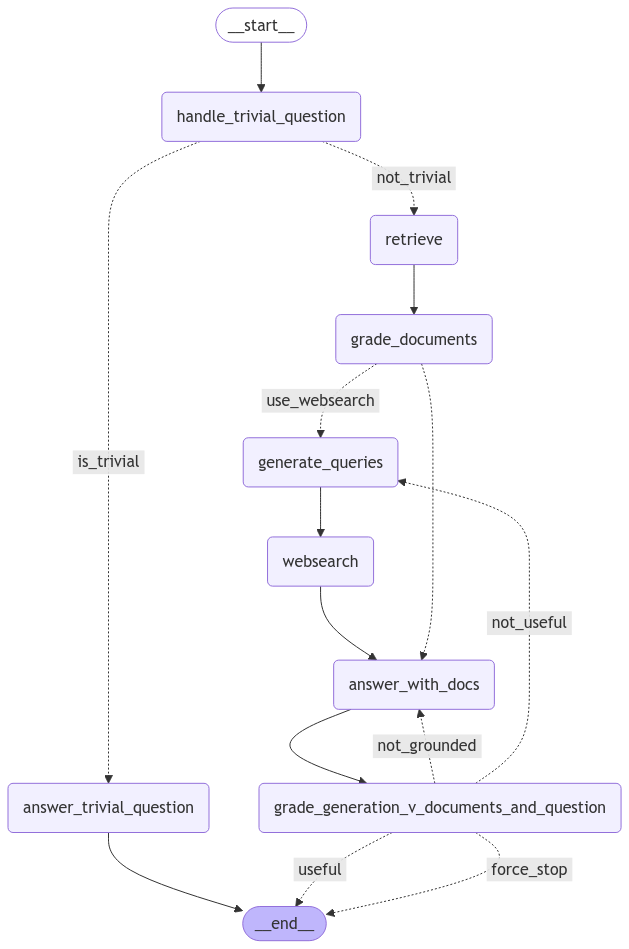

In [18]:
from IPython.display import Image

display(Image(app.get_graph(xray=1).draw_mermaid_png(
)))

In [19]:
from utils.sst import transcribe_audio

In [6]:
text = transcribe_audio("narrative.wav")

In [8]:
text    

"Ready to know what happened this week? Let's dive in. First up, fitness enthusiasts are buzzing about high-intensity interval training, which promises to keep you burning calories long after your workout ends. Meanwhile, in the world of international affairs, Ukraine made headlines by using a naval drone to take down a Russian helicopter, marking a significant moment in their ongoing conflict. As Asia celebrated the arrival of 2025 with spectacular fireworks, Elon Musk stirred controversy in Germany by endorsing a far-right party, leading to a media shake-up. Across the Atlantic, Donald Trump surprised many by supporting Elon Musk and the H-1B visa program, causing ripples within the Republican Party. In entertainment, Lily-Rose Depp is making waves with her role in the new Nasratu film, while Trump mourns the loss of former U.S. President Jimmy Carter, who passed away at 100, leaving behind a legacy of peace and humanitarian work. Spain is facing unrest as public employees deal with 

It will also take the spoken news summary as it will serve also as context so the LLM can avoid redundancy within it's responses

In [28]:
app.invoke({"question":"capital of Spain", "news_summary":text}, thread)["generation"]

already searched queries (if applicable): None
gonna generate 1 queries


'Madrid is indeed the capital of Spain. It became the capital in 1561 when King Philip II moved the royal court there. At that time, Madrid was not the largest city in Spain, but its central location made it strategically important. Over time, Madrid grew into a major city, becoming a hub for transportation and trade, which helped it develop into the vibrant capital it is today.'

In [29]:


app.invoke({"question":"hi, my name is pablo, i want to know the lastest news of ai", "news_summary":text}, thread)["generation"]

already searched queries (if applicable): n_queries=1 queries=['What is the capital of Spain?'] tavily_days=[None] tavily_topic=['general']
gonna generate 3 queries
already searched queries (if applicable): n_queries=3 queries=['latest news in artificial intelligence January 2025', 'recent advancements in AI technology January 2025', 'AI trends and developments January 2025'] tavily_days=[7, 7, 7] tavily_topic=['news', 'news', 'news']
gonna generate 3 queries


"Hi Pablo, the latest news in AI is quite fascinating. Researchers are working on training robots to perform surgeries by watching videos of human doctors. This development is still in the research phase, and these AI systems aren't fully autonomous yet. They need to be approved by the FDA before they can be used in real surgeries. There are concerns about AI's reliability, especially in critical situations where it might make incorrect decisions. So, while the technology is promising, there are still significant hurdles to overcome before it becomes a regular part of surgical procedures."

In [26]:
# app.invoke({"question":"which was my name?", "news_summary":text}, thread)["generation"]

In [56]:
retriever.invoke("current relations between Venezuela and Spain")

In [59]:
for i in a[0]:
    print(i)

('id', None)
('metadata', {'source': './rag_docs\\Maduro_ordena_pedir_a_España_la_extradición_de_la_ex_diputada_opositora_Dinorah_Figuera_El_Mundo.md', 'start_index': 3115})
('page_content', "Current State of Diplomatic Relations Between Venezuela and Spain\n\nVenezuela's diplomatic relations with Spain are strained, impacting extradition processes. Recent tensions have escalated due to Venezuela's arrest of an Argentine officer, Nahuel Gallo, accused of terrorism. This incident has heightened diplomatic friction not only with Argentina but also with Spain, as two Spanish citizens were previously detained under similar charges. These arrests followed Spain's recognition of an opposition candidate in Venezuela, which Venezuela's government viewed as interference.\n\nHistorically, Venezuela and Spain have had a complex relationship, often influenced by political ideologies. Venezuela's government, led by President Nicolás Maduro, aligns with socialist principles, while Spain's political 

In [21]:
app.invoke({"question":"which are the current relationships betwen Venezuela and Spain", "news_summary":text}, thread)["generation"]

"Venezuela and Spain's diplomatic relations are currently strained. Tensions have risen due to Venezuela's arrest of an Argentine officer accused of terrorism, which has also affected Spain, as two Spanish citizens were previously detained on similar charges. This situation follows Spain's recognition of an opposition candidate in Venezuela, which the Venezuelan government saw as interference. These issues have impacted extradition processes and added to the historical ideological differences between the two countries."

In [9]:
# from pprint import pprint
# inputs = {"question": "hi, my name is pablo", "news_summary":text}
# for output in app.stream(inputs, thread):
#     for key, value in output.items():
#         pprint(f"Finished running: {key}:")
# pprint(value["generation"])

from pprint import pprint
inputs = {"question": "hi, which was my name?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: answer_trivial_question:'
("Hello! I'm sorry, but I don't have access to personal information, so I "
 "don't know your name. If you'd like, you can tell me your name or how you'd "
 'like to be addressed!')


In [22]:
from pprint import pprint
inputs = {"question": "tell me the last", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: answer_trivial_question:'
('It seems like your question is incomplete. Could you please provide more '
 'details or clarify what you are asking about?')


In [53]:
text

"Ready to know what happened this week? Let's dive in. First up, fitness enthusiasts are buzzing about high-intensity interval training, which promises to keep you burning calories long after your workout ends. Meanwhile, in the world of international affairs, Ukraine made headlines by using a naval drone to take down a Russian helicopter, marking a significant moment in their ongoing conflict. As Asia celebrated the arrival of 2025 with spectacular fireworks, Elon Musk stirred controversy in Germany by endorsing a far-right party, leading to a media shake-up. Across the Atlantic, Donald Trump surprised many by supporting Elon Musk and the H-1B visa program, causing ripples within the Republican Party. In entertainment, Lily-Rose Depp is making waves with her role in the new Nasratu film, while Trump mourns the loss of former U.S. President Jimmy Carter, who passed away at 100, leaving behind a legacy of peace and humanitarian work. Spain is facing unrest as public employees deal with 

In [80]:
# vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3}).invoke("current relations between Venezuela and Spain")

In [21]:
from pprint import pprint
inputs = {"question": "¿Qué ocurrió en el atentado de Nueva Orleás?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
'Finished running: answer_with_docs:'
forcing stop of the graph...
'Finished running: grade_generation_v_documents_and_question:'
('En el atentado de Nueva Orleans, al menos 15 personas murieron y decenas '
 'resultaron heridas cuando un conductor embistió con una camioneta a una '
 'multitud en Bourbon Street el día de Año Nuevo. Entre las víctimas se '
 'encontraba Tiger Bech, un exjugador de fútbol de Princeton, quien murió a '
 'causa de lesiones internas. Otro estudiante, Kareem Badawi, de la '
 'Universidad de Alabama, también perdió la vida. Las víctimas sufrieron '
 'principalmente traumas contundentes, y los heridos fueron trasladados a '
 'varios hospitales de la zona para recibir tratamiento. La comunidad ha '
 'estado recordando a las víctimas con tributos y vigili

#### PROBLEM #3: Determine how much `n_result` sources do we get for each search query

- We should consider those questions which may lead to incoherences or detailed questions, to search for more thrustworthy sources

- Decreasing `n_results` will also reduce the latency of the model


some values:
> With `n_values=1` --> took 7,7 sec for inference

> With `n_values=2` --> 12 sec

In [24]:
value

{'decission': 'useful', 'feedback': None, 'iterations': 1}

In [27]:
from pprint import pprint
inputs = {"question": "capital of spain", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): None
'Finished running: generate_queries:'
gonna generate 1 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
'The capital of Spain is Madrid.'


In [28]:
from pprint import pprint
inputs = {"question": "which is the current political party at Venezuela?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=1 queries=['capital of Spain'] tavily_days=[None] tavily_topic=['general']
'Finished running: generate_queries:'
gonna generate 1 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
already searched queries (if applicable): n_queries=1 queries=['current ruling political party in Venezuela 2025'] tavily_days=[7] tavily_topic=['news']
'Finished running: generate_queries:'
gonna generate 1 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
forcing stop of the graph...
'Finished running: grade_generation_v_documents_and_question:'
('The current ruling political party in Venezuela is the United Socialist '
 'Party of Venezuela (PSUV). Nicolás Maduro is the leader of this party and '
 'has been in power since 2013.')


In [29]:
from pprint import pprint
inputs = {"question": "which is the importance of latency in AI. audio models? ", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=1 queries=['current ruling political party in Venezuela 2025'] tavily_days=[None] tavily_topic=['general']
'Finished running: generate_queries:'
gonna generate 3 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
'Finished running: answer_with_docs:'
forcing stop of the graph...
'Finished running: grade_generation_v_documents_and_question:'
('Latency in AI audio models is crucial because it directly affects the '
 'responsiveness and usability of applications that rely on real-time '
 'interactions. Low latency ensures that these systems can process inputs and '
 'generate outputs quickly, which is essential for a smooth user experience. '
 'For example, in applications like voice assistants or gaming, low latency '
 'allows for real-tim

In [157]:
from pprint import pprint
inputs = {"question": "Is there is any risk of new COVID infection in China?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=3 queries=['importance of latency in AI audio models', 'how latency affects AI audio processing', 'latency in AI audio models explained'] tavily_days=[None, None, None] tavily_topic=['general', 'general', 'general']
'Finished running: generate_queries:'
gonna generate 2 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
('Yes, there is a risk of new COVID infections in China, but the current '
 'concern is more about a surge in respiratory illnesses, including human '
 'metapneumovirus (HMPV). While there is an increase in these infections, '
 "China's National Disease Control and Prevention Administration has reported "
 'that the country is safe to visit. The situation is not considered a global '
 'health emergency by the World Health Organization, and there is more herd '
 'immunity against HMPV

In [158]:
from pprint import pprint
inputs = {"question": "would it be the risk that new COVID infection in China reaches Europe?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=2 queries=['current COVID-19 situation in China', 'risk of new COVID-19 variants in China'] tavily_days=[7, 7] tavily_topic=['news', 'news']
'Finished running: generate_queries:'
gonna generate 3 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: answer_with_docs:'
already searched queries (if applicable): n_queries=3 queries=['COVID-19 spread from China to Europe risk assessment', 'impact of new COVID-19 variants on international travel', 'measures taken by Europe to prevent COVID-19 spread from China'] tavily_days=[7, 7, 7] tavily_topic=['news', 'news', 'news']
'Finished running: generate_queries:'
gonna generate 2 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
("The context provided doesn't specifically address the risk of new COVID "
 'infections 

____________

In [136]:
from pprint import pprint
inputs = {"question": "what is the left-wing party in politics in spain", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): None
'Finished running: generate_queries:'
gonna generate 1 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
('In Spain, the main left-wing political parties are Podemos and the Spanish '
 "Socialist Workers' Party (PSOE). Podemos is known for its left-wing to "
 'far-left stance, while PSOE is a center-left party. Both have been involved '
 'in coalition governments, with PSOE currently being part of the ruling '
 'coalition alongside Sumar, a new left-wing platform.')


In [26]:
from pprint import pprint
inputs = {"question": "which was the name of Franco Hitler", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: answer_trivial_question:'
('It seems like there might be some confusion in your question. Francisco '
 'Franco and Adolf Hitler were two different historical figures. Francisco '
 'Franco was the dictator of Spain from 1939 until his death in 1975. Adolf '
 'Hitler was the dictator of Nazi Germany from 1933 to 1945. If you meant to '
 'ask about their relationship or any specific aspect of their interactions, '
 'feel free to provide more details!')


In [ ]:
#TODO: we need to handle when questions are not grabbed correctly so it can lead to infinite recursions/iterations for questions like "I want to know the last"

### Bug #1: (DONE) Missleading questions

In [30]:
from pprint import pprint


#TODO: sample BUG in the graph
#When you ask questions which are missleading or not real, the graph will fall into an infinite loop
#this is because once it ensures the returned docs are related to it, it will ensure the question actually responds to the docs
#so it won't realize that the question is not real or cohesive hence it won't never get a precisse answer
#todo: porque nunca vas a responder de forma precisa a una pregunta errónea, porque los datos de web/docs no proveeran tal respuesta, sino una respuesta valida

inputs = {"question": "why do the afd Germany party supports PSOE?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=3 queries=['importance of latency in AI audio models', 'how latency affects AI audio processing', 'impact of latency on AI-driven audio applications'] tavily_days=[None, None, None] tavily_topic=['general', 'general', 'general']
'Finished running: generate_queries:'
gonna generate 3 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
('The question seems to be based on a misunderstanding. The AfD, or '
 'Alternative for Germany, is a far-right political party in Germany, and '
 'there is no indication that they support the PSOE, which is a '
 "social-democratic party in Spain. The context provided discusses Elon Musk's "
 'support for the AfD, but it does not mention any connection or support '
 'between the AfD and PSOE. These two partie

______________

### BUG #2: (DONE) If the provided context is `not_useful`, we need to let know to the query writer to make different queries to the already searched ones

##### NOTE: We already harcoded to not search in the RAG but instead running websearch




In [138]:
from pprint import pprint


#TODO: sample BUG in the graph
inputs = {"question": "who is the nephew of martin luther king?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): None
'Finished running: generate_queries:'
gonna generate 1 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
("Martin Luther King Jr.'s nephew is Isaac Newton Farris Jr. He has been "
 "involved in various activities related to his uncle's legacy and has spoken "
 'publicly on social issues.')


In [17]:
from pprint import pprint
inputs = {"question": "who is the nephew of Francisco Hitler?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: answer_trivial_question:'
('There is no widely recognized historical figure named Francisco Hitler, and '
 'Adolf Hitler, the infamous leader of Nazi Germany, did not have a known '
 'nephew by that name. If you meant someone else or if this is a fictional or '
 'lesser-known figure, please provide more context or clarify your question.')


In [31]:
from pprint import pprint
inputs = {"question": "who's the grandson of grandson of pablo escobar?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=3 queries=['AfD Germany support for PSOE Spain', 'AfD and PSOE political relationship', 'AfD Germany PSOE Spain collaboration'] tavily_days=[7, 7, 7] tavily_topic=['news', 'news', 'news']
'Finished running: generate_queries:'
gonna generate 2 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
'Finished running: answer_with_docs:'
forcing stop of the graph...
'Finished running: grade_generation_v_documents_and_question:'
('The question about the "grandson of the grandson of Pablo Escobar" is based '
 'on an incorrect assumption. The provided context only gives information '
 "about Pablo Escobar's immediate family, including his children, Juan Pablo "
 '(also known as Sebastian Marroquin) and Manuela Escobar. There is no mention '
 'of an

In [93]:
# from pprint import pprint
# inputs = {"question": "Hey, I want to know the last", "news_summary":text}
# for output in app.stream(inputs, thread):
#     for key, value in output.items():
#         pprint(f"Finished running: {key}:")
# pprint(value["generation"])

### BUG #5 Caer bucle infinito con `not_useful`, volviendo a ejecutar websearch una y otra vez sin parar

In [36]:
from pprint import pprint
inputs = {"question": "¿Qué ocurrió en el atentado de Nueva Orleás?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
already searched queries (if applicable): n_queries=3 queries=['Javier Milei meeting with Venezuelan opposition in Argentina', 'reason for Javier Milei and Venezuelan opposition meeting in Argentina', 'Javier Milei Venezuelan opposition meeting January 2025'] tavily_days=[7, 7, 7] tavily_topic=['news', 'news', 'news']
'Finished running: generate_queries:'
gonna generate 2 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
forcing stop of the graph...
'Finished running: grade_generation_v_documents_and_question:'
('El atentado en Nueva Orleans ocurrió el 1 de enero de 2025, cuando '
 'Shamsud-Din Jabbar condujo una camioneta eléctrica hacia una multitud en la '
 'calle Bourbon, durante las celebraciones de Año Nuevo. Este ataque resultó '
 'en la muert

In [35]:
from pprint import pprint
inputs = {"question": "why did Javier Milei and the Venezuelan oppositor meet in Argentina?","news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=2 queries=['atentado Nueva Orleans', 'incidente reciente Nueva Orleans'] tavily_days=[7, 7] tavily_topic=['news', 'news']
'Finished running: generate_queries:'
gonna generate 3 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
('Javier Milei and Venezuelan opposition leader Edmundo González met in '
 "Argentina as part of González's international tour. This meeting took place "
 "just days before Nicolás Maduro's planned inauguration for a third term, "
 'which is not recognized by some countries, including the United States. '
 'González, recognized by the U.S. as the legitimate president-elect of '
 'Venezuela, is seeking international support and highlighting the plight of '
 "Venezuelans under Maduro's regime. The meeting with Milei

In [37]:
tavily_client = TavilyClient()

web_search_tool = TavilySearchResults(k=3)

In [38]:
web_search_tool.invoke("son of leo messi")

[{'url': 'https://www.geeksforgeeks.org/lionel-messi-kids/',
  'content': "Who are Lionel Messi's Kids: All About Messi and Antonela 3 Sons - GeeksforGeeks Tutorials Python Tutorial Python Tutorial Python Data Visualization Tutorial Mateo Messi Roccuzzo, born on September 11, 2015, in Barcelona, Spain, is the second son of soccer icon Lionel Messi and Antonela Roccuzzo. Ciro Messi Roccuzzo, the youngest son of soccer superstar Lionel Messi and his wife Antonela Roccuzzo, was born on March 10, 2018, in Barcelona, Spain. Antonela Roccuzzo, born on February 26, 1988, in Rosario, Argentina, is widely known as the wife of soccer superstar Lionel Messi and the mother of their three children. Lionel Messi and Antonela Roccuzzo's three sons, Thiago, Mateo, and Ciro, are growing up in the spotlight, often seen supporting their father's illustrious soccer career. Python Tutorial"},
 {'url': 'https://rimpost.com/meet-lionel-messis-three-sons-thiago-mateo-and-ciro',
  'content': 'Lionel Messi and 

In [41]:
from langchain.tools import TavilySearchResults
# import tavily_client  # Assuming Tavily API is installed and set up

# Use LangChain's TavilySearchResults with 'k' to control results for speed
def search_with_langchain(query, k):
    # Initialize the LangChain TavilySearchResults tool with 'k'
    web_search_tool = TavilySearchResults(k=k)
    results = web_search_tool.invoke(query)
    return results

# Use Tavily API client directly with 'max_results' to control speed
def search_with_tavily_api(query, max_results):
    result = tavily_client.search(
        query,
        max_results=max_results,  # Set the number of results
        include_raw_content=True,
        topic="general"
    )
    return result

# Test the functions with query
query = "Artificial Intelligence"

# Test with LangChain's TavilySearchResults (using 'k')
print("LangChain Search Results (k=3):")
langchain_results = search_with_langchain(query, k=3)
print(langchain_results)
print(f"Length of LangChain results: {len(langchain_results)}\n")

# Test with Tavily API Client (using 'max_results')
print("Tavily API Search Results (max_results=3):")
tavily_api_results = search_with_tavily_api(query, max_results=3)
print(tavily_api_results)
print(f"Length of Tavily API results: {len(tavily_api_results)}")



LangChain Search Results (k=3):
[{'url': 'https://www.britannica.com/technology/artificial-intelligence', 'content': 'For example, a program that learns the past tense of regular English verbs by rote will not be able to produce the past tense of a word such as jump unless it previously had been presented with jumped, whereas a program that is able to generalize can learn the “add ed” rule and so form the past tense of jump based on experience with similar verbs. The real nature of the wasp’s instinctual behaviour is revealed if the food is moved a few inches away from the entrance to her burrow while she is inside: on emerging, she will repeat the whole procedure as often as the food is displaced. The program might then store the solution with the position so that the next time the computer encountered the same position it would recall the solution. Artificial intelligence is the ability of a computer or computer-controlled robot to perform tasks that are commonly associated with the\

In [42]:
langchain_results

[{'url': 'https://www.britannica.com/technology/artificial-intelligence',
  'content': 'For example, a program that learns the past tense of regular English verbs by rote will not be able to produce the past tense of a word such as jump unless it previously had been presented with jumped, whereas a program that is able to generalize can learn the “add ed” rule and so form the past tense of jump based on experience with similar verbs. The real nature of the wasp’s instinctual behaviour is revealed if the food is moved a few inches away from the entrance to her burrow while she is inside: on emerging, she will repeat the whole procedure as often as the food is displaced. The program might then store the solution with the position so that the next time the computer encountered the same position it would recall the solution. Artificial intelligence is the ability of a computer or computer-controlled robot to perform tasks that are commonly associated with the\xa0intellectual\xa0processes c

In [43]:
tavily_api_results

{'query': 'Artificial Intelligence',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Artificial intelligence (AI) | Definition, Examples, Types, Applications, Companies, & Facts',
   'url': 'https://www.britannica.com/technology/artificial-intelligence',
   'content': 'For example, a program that learns the past tense of regular English verbs by rote will not be able to produce the past tense of a word such as jump unless it previously had been presented with jumped, whereas a program that is able to generalize can learn the “add ed” rule and so form the past tense of jump based on experience with similar verbs. The real nature of the wasp’s instinctual behaviour is revealed if the food is moved a few inches away from the entrance to her burrow while she is inside: on emerging, she will repeat the whole procedure as often as the food is displaced. The program might then store the solution with the position so that the next time the computer encount

______________

### BUG (**TO SOLVE**) #5: HANDLE the short-term memmory for the agent to have context also about what was [asked,answered] before


> e.g which can be the connection between both attacks?

- The LLM here should renember that in the past messages, there was one record with ``[input="what happened with the new orleans attack?", output="..."]``

- Also we need to ensure we handle the max context windows of the LLM

___________________________

## Tweaking `narrative_graph.py`